# 1- Importing Libraries

In [2]:
import os
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

# 2- Loading Dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full,
                                                  test_size=0.3,
                                                  random_state=123)

print("전체 학습 데이터: {} 레이블: {}".format(X_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(X_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(X_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(X_test.shape, y_test.shape))

전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (35000, 32, 32, 3) 레이블: (35000, 1)
검증 데이터: (15000, 32, 32, 3) 레이블: (15000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


In [5]:
print(X_val)
print(type(X_val))

[[[[163 163 173]
   [159 159 168]
   [160 160 168]
   ...
   [159 161 173]
   [159 161 173]
   [159 161 173]]

  [[161 161 171]
   [158 158 167]
   [161 161 169]
   ...
   [159 162 173]
   [159 161 174]
   [159 161 174]]

  [[158 158 168]
   [156 156 166]
   [160 160 169]
   ...
   [158 160 172]
   [158 160 173]
   [159 161 174]]

  ...

  [[119 108  62]
   [123 106  52]
   [132 113  60]
   ...
   [128 107  65]
   [ 86  78  35]
   [ 73  78  31]]

  [[105 101  44]
   [113 101  43]
   [101  90  40]
   ...
   [137 113  71]
   [ 83  76  35]
   [ 61  73  24]]

  [[ 86  89  26]
   [107  99  39]
   [ 91  84  28]
   ...
   [123 106  61]
   [ 80  76  30]
   [ 71  80  29]]]


 [[[157 144 106]
   [162 148 110]
   [170 157 116]
   ...
   [228 221 201]
   [168 167 163]
   [102 101  91]]

  [[154 143 106]
   [161 148 110]
   [168 157 115]
   ...
   [229 222 196]
   [201 206 206]
   [107 109 101]]

  [[146 137 105]
   [155 144 112]
   [165 156 117]
   ...
   [244 240 221]
   [221 226 227]
   [113 115

In [6]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의합니다.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

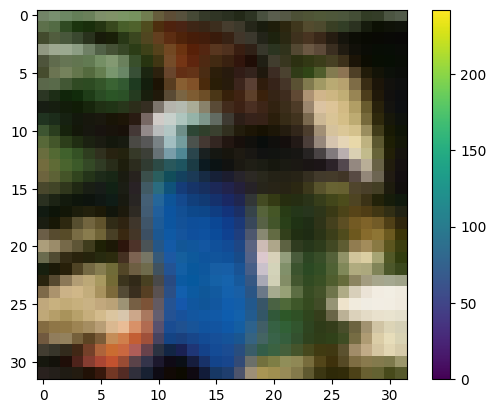

2 : bird


/var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/ipykernel_11781/1363441063.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(int(y_train[number]), ':', class_names[int(y_train[number])])


In [7]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화합니다.
number = 333
plt.figure()
plt.imshow(X_train[number])
plt.colorbar()
plt.show()
print(int(y_train[number]), ':', class_names[int(y_train[number])])

# 3- DeepTuner

In [8]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

# 4- Building Model

In [9]:
from ipaddress import summarize_address_range
from pyexpat import model


def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs'))
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu'))
    model.add(tf.keras.layers.Flatten())
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs'))
    # model.compile(optimizer = 'adam',loss='categorical_crossentropy',
    model.compile(optimizer = 'adam',loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

# 5- Keras Tuner

In [10]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')

my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=10)

2024-04-09 16:48:22.977162: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-09 16:48:22.977195: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-09 16:48:22.977202: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-09 16:48:22.977228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 16:48:22.977245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
7                 |7                 |num_layers
32                |32                |units_0
2                 |2                 |n_connections
64                |64                |n_nodes

Epoch 1/10


2024-04-09 16:48:23.917066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - accuracy: 0.2607 - loss: 2.1408
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 45s 20ms/step - accuracy: 0.4700 - loss: 1.4633
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 46s 21ms/step - accuracy: 0.5371 - loss: 1.3058
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.5822 - loss: 1.1602
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 54s 25ms/step - accuracy: 0.6182 - loss: 1.0684
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - accuracy: 0.6616 - loss: 0.9665
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 50s 23ms/step - accuracy: 0.6885 - loss: 0.8815
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.7180 - loss: 0.8014
Epoch 9/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.7464 - loss: 0.7164
Epoch 10/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.7700 - loss: 0.6567
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5748 - loss: 1.3811


FatalValueError: Expected the returned dictionary from Tuner.run_trial() to have the specified objective, accuracy, as one of the keys. Received: {'loss': 1.3638086318969727, 'compile_metrics': 0.581333339214325}.

# 6- Checking Model

In [22]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       663,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,810 (2.76 MB)

 Trainable params: 724,810 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

# 7- Training Optimum Model

In [23]:
model.fit(X_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step - accuracy: 0.2691 - loss: 2.0465
Epoch 2/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.4690 - loss: 1.4448
Epoch 3/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.5505 - loss: 1.2452
Epoch 4/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.6027 - loss: 1.1129
Epoch 5/5
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - accuracy: 0.6474 - loss: 0.9921


# 8- Evaluating Model

In [24]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5935 - loss: 1.1374


[1.1477307081222534, 0.5965999960899353]

# 9- Saving Model

In [25]:
save_path = '/Users/kenny_jung/aiffel/data/mlops/best_model'
fname = os.path.join(save_path, 'model.h5')  # Changed to include .h5 extension
model.save(fname)

# 10- Light Model

In [26]:
# 모델 파일 경로
model_path = '/Users/kenny_jung/aiffel/data/mlops/best_model/model.h5'

# 모델 로드
model = tf.keras.models.load_model(model_path)

# 로드된 모델 요약 출력
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 22, 22, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 20, 20, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 18, 18, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       663,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 724,812 (2.76 MB)

 Trainable params: 724,810 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# 11- Transformation to tflite

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/tmpu3pr4_is/assets


INFO:tensorflow:Assets written to: /var/folders/b9/d_8nll_s47g6w2x0spndwwl80000gn/T/tmpu3pr4_is/assets


: 